### Main Updates
* Dataset now includes average passenger count and trip duration
* Final version of fare hike correction
* For routes with no ride, replace non-count quantities by average 

### load packages

In [35]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# ! pip install pyarrow fastparquet tqdm seaborn

### load data for range of time of choice
Two years and three months of data.

In [37]:
# preprocess months and years to an (N,2)-array
months = np.arange(11,12+1,1)
years = np.arange(2022,2022+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

# add three months
month_year = np.vstack([month_year, [2023,1]])

In [38]:
month_year

array([[2022,   11],
       [2022,   12],
       [2023,    1]])

### Filter Manhattan Only and Remove Islands as in 01_e_adjacency_graph.ipynb

In [39]:
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [40]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True, taxi_zones=taxi_zones)
ts.head()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:22<00:00,  7.53s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,2022-11-01 00:00:00-04:00,4,4,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-01 00:00:00-04:00,13,4,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-11-01 00:00:00-04:00,24,4,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-11-01 00:00:00-04:00,41,4,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-01 00:00:00-04:00,42,4,0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
ts.pickup_datetime.min(), ts.pickup_datetime.max()

(Timestamp('2022-11-01 00:00:00-0400', tz='America/New_York'),
 Timestamp('2023-01-31 23:00:00-0500', tz='America/New_York'))

In [42]:
# basic checks, notice our code accounts for Daylight Savings Time
print('Min Date: ', ts.pickup_datetime.min())
print('Max Date: ', ts.pickup_datetime.max())
print('Taxi Zones: ' + str(ts.PULocationID.unique().min()) + ' to ' + str(ts.PULocationID.unique().max()) )
print('Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Min Date:  2022-11-01 00:00:00-04:00
Max Date:  2023-01-31 23:00:00-05:00
Taxi Zones: 4 to 263
Memory Usage (MB):  345.45981216430664


In [43]:
ts.dtypes

pickup_datetime    datetime64[us, America/New_York]
DOLocationID                                  int32
PULocationID                                  int32
counts                                        int32
total_amount                                float32
tip_amount                                  float32
fare_amount                                 float32
trip_distance                               float32
passenger_count                             float32
trip_duration                               float32
dtype: object

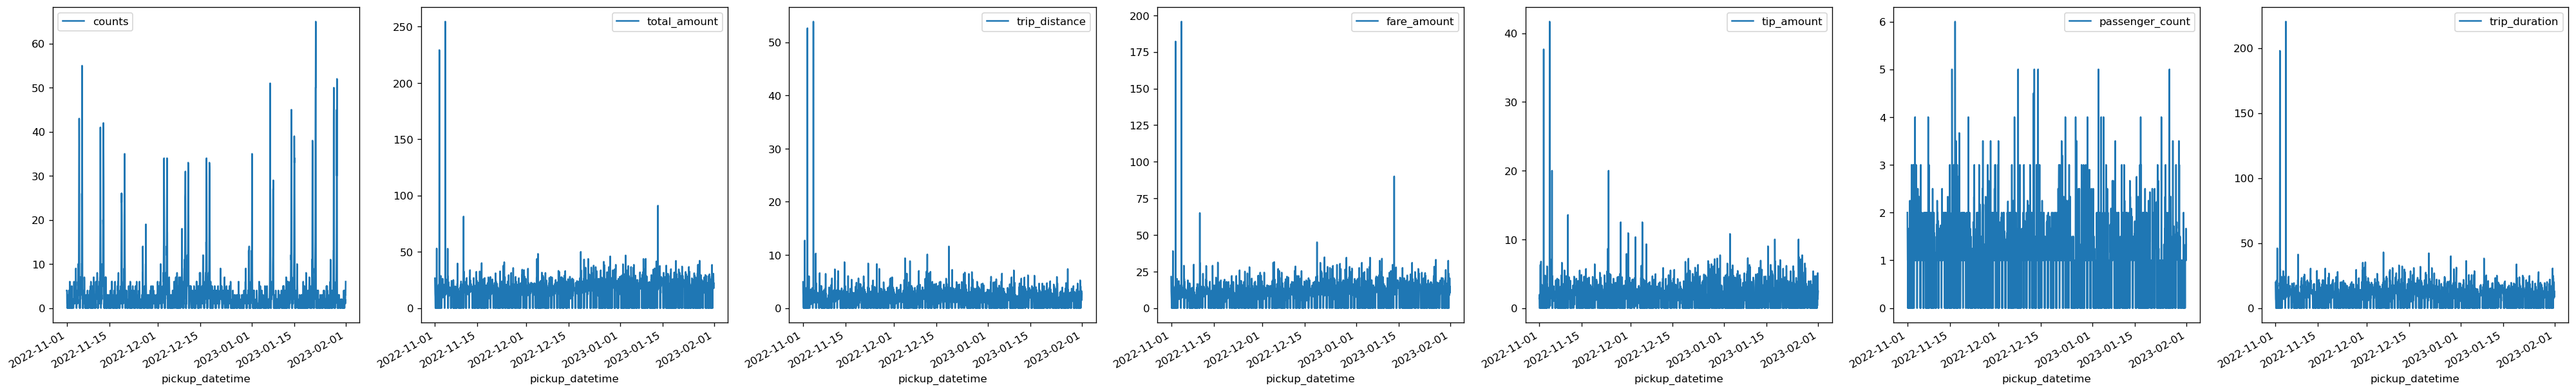

In [44]:
ts_z = pr.route_to_pulocation(ts, 4)
fig, axes = plt.subplots(figsize = (6*7, 6), dpi = 120, nrows = 1, ncols = 7)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'passenger_count', 'trip_duration']):
    ts_z.plot(x = 'pickup_datetime', y = col, ax = axes[i])

### postprocessing
* Adjust quantities affected by rate hike
* Account for routes with no counts in a given hour

In [45]:
ts_p = pr.postprocess_data(ts)

In [46]:
ts_p[ts_p['counts'] == 0]

,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,2022-11-01 00:00:00-04:00,4,4,0,30.518360,6.591297,21.342051,2.950160,1.372931,12.221848
1,2022-11-01 00:00:00-04:00,13,4,0,29.844707,4.719219,20.565851,4.362447,1.244681,13.758333
2,2022-11-01 00:00:00-04:00,24,4,0,42.791527,6.357694,32.054375,7.230000,1.250000,26.061459
3,2022-11-01 00:00:00-04:00,41,4,0,43.907253,6.991219,33.573654,7.754231,1.692308,25.050640
4,2022-11-01 00:00:00-04:00,42,4,0,41.892982,5.580771,33.150784,8.386562,1.593750,21.982813
...,...,...,...,...,...,...,...,...,...,...
8232734,2023-01-31 23:00:00-05:00,237,263,0,15.595685,2.131291,9.006692,1.220499,1.372485,8.059943
8232738,2023-01-31 23:00:00-05:00,244,263,0,35.369675,5.417495,27.190071,6.121233,1.324399,20.502565
8232739,2023-01-31 23:00:00-05:00,246,263,0,33.726570,4.864247,24.913157,4.739378,1.402471,25.362816
8232740,2023-01-31 23:00:00-05:00,249,263,0,36.772972,5.565928,26.998831,5.400193,1.364449,26.576511


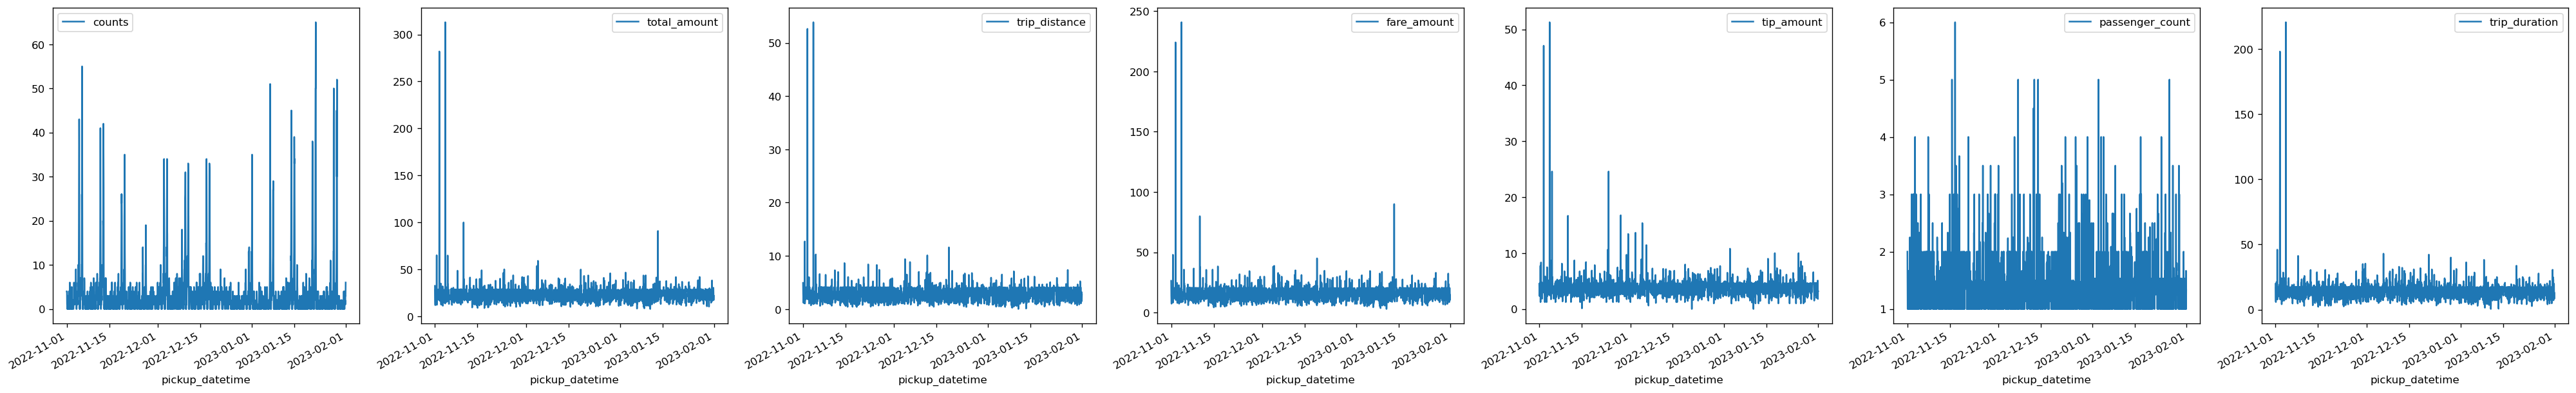

In [47]:
ts_z = pr.route_to_pulocation(ts_p, 4)
fig, axes = plt.subplots(figsize = (6*7, 6), dpi = 120, nrows = 1, ncols = 7)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'passenger_count', 'trip_duration']):
    ts_z.plot(x = 'pickup_datetime', y = col, ax = axes[i])